In [1]:
import json
import tarfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from pymatgen.core import Structure
from megnet.models import MEGNetModel
from megnet.data.crystal import CrystalGraph
from sklearn.model_selection import train_test_split

# Загрузка данных

In [2]:
file = tarfile.open('data/dichalcogenides_public.tar.gz')
file.extractall('data/')
file.close()

file = tarfile.open('data/dichalcogenides_private.tar.gz')
file.extractall('data/')
file.close()

In [3]:
def read_pymatgen_dict(file):
    with open(file, "r") as f:
        d = json.load(f)
    return Structure.from_dict(d)

In [4]:
dataset_path = Path('data/dichalcogenides_public')
targets = pd.read_csv(dataset_path / "targets.csv", index_col=0)
struct = {
    item.name.strip(".json"): read_pymatgen_dict(item)
    for item in (dataset_path / "structures").iterdir()
}

data = pd.DataFrame(columns=["structures"], index=struct.keys())
data = data.assign(structures=struct.values(), targets=targets)

train, test = train_test_split(data, test_size=0.25, random_state=666)

# Решение

## Метрика

In [5]:
def energy_within_threshold(prediction, target):
    e_thresh = 0.02
    error_energy = tf.math.abs(target - prediction)
    success = tf.math.count_nonzero(error_energy < e_thresh)
    total = tf.size(target)
    return success / tf.cast(total, tf.int64)

## Обучение

In [11]:
nfeat_bond = 10
r_cutoff = 4
gaussian_centers = np.linspace(0, r_cutoff + 1, nfeat_bond)
gaussian_width = 0.8
    
model =  MEGNetModel(
    graph_converter=CrystalGraph(cutoff=r_cutoff),
    centers=gaussian_centers,
    width=gaussian_width,
    loss=["MAE"],
    npass=2,
    lr=5e-4,
    metrics=energy_within_threshold
)

history = model.train(
    train.structures,
    train.targets,
    epochs=200,
    batch_size=128,
)

loss = history.history.history['loss']
EwT = history.history.history['energy_within_threshold']

c:\Users\nikit\anaconda3\envs\NN_Lab7\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/200
18/18 [==============================] - 20s 250ms/step - loss: 0.6203 - energy_within_threshold: 0.0213
Epoch 2/200
18/18 [==============================] - 5s 249ms/step - loss: 0.4588 - energy_within_threshold: 0.0048
Epoch 3/200
18/18 [==============================] - 5s 250ms/step - loss: 0.4576 - energy_within_threshold: 0.0171
Epoch 4/200
18/18 [==============================] - 5s 250ms/step - loss: 0.4634 - energy_within_threshold: 0.0000e+00
Epoch 5/200
18/18 [==============================] - 5s 252ms/step - loss: 0.4605 - energy_within_threshold: 4.3403e-04
Epoch 6/200
18/18 [==============================] - 5s 251ms/step - loss: 0.4609 - energy_within_threshold: 0.0000e+00
Epoch 7/200
18/18 [==============================] - 5s 250ms/step - loss: 0.4608 - energy_within_threshold: 0.0000e+00
Epoch 8/200
18/18 [==============================] - 5s 270ms/step - loss: 0.4603 - energy_within_threshold: 0.0000e+00
Epoch 9/200
18/18 [==============================] 

# Результаты

## История обучения

Text(0.5, 0, 'Эпоха')

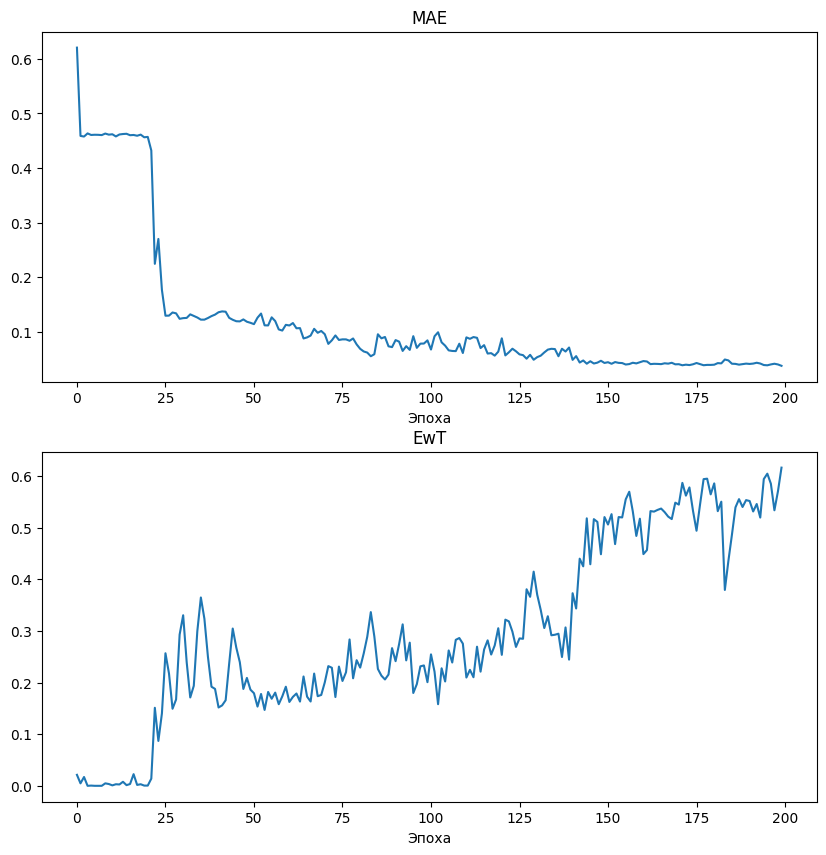

In [14]:
f, ax = plt.subplots(2, figsize=(10, 10))
ax[0].plot(loss); ax[0].set_title('MAE'); ax[0].set_xlabel('Эпоха')
ax[1].plot(EwT); ax[1].set_title('EwT'); ax[1].set_xlabel('Эпоха')

## Метрика

In [12]:
y_pred = model.predict_structures(test.structures).flatten()
y_true = test.targets.values
print(f"EwT: {round(energy_within_threshold(y_pred, y_true).numpy(), 4)}")

EwT: 0.6146


## Построение прогноза на приватной выборке

In [13]:
dataset_path = Path('data/dichalcogenides_private')
struct = {item.name.strip('.json'): read_pymatgen_dict(item) for item in (dataset_path/'structures').iterdir()}
private_test = pd.DataFrame(columns=['id', 'structures'], index=struct.keys())
private_test = private_test.assign(structures=struct.values())
private_test = private_test.assign(predictions=model.predict_structures(private_test.structures))
private_test[['predictions']].to_csv('submission.csv', index_label='id')